# What is DICOM?
> Understanding DICOM and using fastai to read and work with DICOM images
- toc:true
- branch: master
- badges: true
- comments: true
- author: Mohamed Arshath
- categories: [fastai, medical, interpretability]

> Note: Most of the codes used in this blog are either taken from fastbook or fastai docs




# What is DICOM?

*   DICOM stands for **D**igital **I**maging and **CO**mmunication in **M**edicine
*   It is a software integration standard that is used in medical imaging
*   It is the standard that establishes rules that allows different medical imaging modalities (such as X-Rays, Ultrasound, CT, MRI) from different vendors and hospitals to exchange information between them

There core of DICOM 

1. DICOM File Format

*   This is the important for part for DL.
*   DICOM images uses the `.dcm` extension
*   `.dcm` allows patient data, image pixel values to be stored under different tags
*   Like mentioned above apart from images, DICOM also contains patient details (such as patient name and age) and image acqusition data (such as type of equipment used)

2. DICOM Network protocol

*   The protocol allows for information exchange between different imaging modalities that is connected to the hospital network 
*   Used for searching for images from the archive and to display images on the workstation
*   This protocol can also be used to monitor treatment, schedule procedures, report status

Let's use `fastai` to read a `dcm` file and use it to understand the information it contains. We will use the [SIIM-ACR Pneumothorax Segentation](https://link.springer.com/article/10.1007/s10278-019-00299-9) dataset.

In [ ]:
#hide
! pip install fastai -q --upgrade
! pip install pydicom kornia opencv-python scikit-image nbdev -q

     |████████████████████████████████| 194kB 18.8MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 1.9MB 18.6MB/s 
     |████████████████████████████████| 225kB 46.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [ ]:
#hide
import fastai 
print(fastai.__version__)

2.2.5


In [ ]:
#collapse-hide
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
#
# downloading the dataset
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [ ]:
#
# reading the dcm files
items = get_dicom_files(pneumothorax_source/f"train/")

In [ ]:
#
# lets read the dcm file for patient 11
patient = 11
xray_sample = items[patient].dcmread()

In [ ]:
#
# lets take a look at the DICOM metafile
xray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10731.1517875225.339875
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10731.1517875225.339875
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

As can be seen, the dataset file has many rows. Each row contains a data element. 
 
An example of a data element is 
`(0028, 0010) Rows US: 1024`
 
Let's break down the data element
 
`(0028, 0010)` is the tag. There are two parts - Group (`0028`) and Element (`0010`). From our example of patient 11 above, we can see that Group `0010`  groups all patient details. 
 
In our data element example, the tag is followed by `Rows` which describes the data element. Following the tag and its description, the next value is Value Representation (VR) which describes the data type of the data element. In our example, the VR is `US` which means `Unsigned Short`. The VR is then followed by Value Length. In our example, there are 1024 rows. 
 
There are 1,000s of data elements in the DICOM. In this, we will focus on the `0028` group which describes different image/pixel related attributes and `(7fe0, 0010)` which describes and contains the pixel data.
 
 
*   `(0028, 0002) Samples per pixel` - This indicates if the image is grayscale (1) or RGB (3). In our example, we have a grayscale image.
*   `(0028, 0004) Photometric Interpretation` - describes the color space of our image. Some of the possible values are - `MONOCHROME`, `MONOCHROME2`, `PALETTE COLOR`, `RGB`. In our case it is `MONOCHROME2` where low values are dark and high values are bright. It is the opposite in `MONOCHROME`. `PALETTE COLOR` contains a color image with a single sample per pixel. `RGB` describes red, green and blue image planes. For `RGB`, samples per pixel would be 3.
*   `(0028, 0010) Rows` - describes the number of rows in the image. In our example, there are 1024 rows.
*   `(0028, 0011) Columns` - describes the number of columns in the image. In our example, there are 1024 columns.
*   `(0028, 0030) Pixel Spacing` - describes the distance between centers of two neighbouring pixels. In our example `[0.19431099999999998, 0.19431099999999998]`, the first number is the Row Spacing, the second number is the Column Spacing.
*   `(0028, 0100) Bits Allocated` - Number of bits allocated for each pixel sample. 
*   `(0028, 0101) Bits Stored` - Number of bits stored for each pixel sample. A 8 bits image would have pixel value between 0-255.
*   `(0028, 0102) High Bit` - Most significant bit for pixel sample data. Each sample shall have the same high bit.
*   `(0028, 0103) Pixel Representation` - can either be unsigned(0) or signed(1). If you are like me and need a refresher on signed vs unsigned integer, here is a [link](https://stackoverflow.com/questions/5739888/what-is-the-difference-between-signed-and-unsigned-int#:~:text=In%20laymen's%20terms%20an%20unsigned,negative%20values%20it%20can%20assume.)
*   `(0028, 2110) Lossy Image Compression` - Specifies whether an Image has undergone lossy compression. `00` image has not been subjected to lossy compression. `01` image has been subjected to lossy compression. lossy compression or irreversible compression is the class of data encoding methods that uses inexact approximations and partial data discarding to represent the content. These techniques are used to reduce data size for storing, handling, and transmitting content.
*   `(0028, 2114) Lossy Image Compression Method` - the methods used in Lossy Image compression. ISO_10918_1 : JPEG Lossy Compression, ISO_14495_1 : JPEG-LS Near-lossless Compression, ISO_15444_1 : JPEG 2000 Irreversible Compression : ISO_13818_2 MPEG2 Compression, ISO_14496_10 : MPEG-4 AVC/H.264 Compression, ISO_23008_2 : HEVC/H.265 Lossy Compression. In our example, it is `ISO_10918_1` which is `JPEG Lossy Compression`.
*   `(7fe0, 0010) Pixel Data` - an array of pixel data. Data type is OB. Let's take a look below.
 
Apart from the above, let's also understand the below
*   ` (0008,0060) Modality` - Type of equipment that originally acquired the data used to create the images in this Series.For all the different values, refer [here](https://dicom.innolitics.com/ciods/ct-image/general-series/00080060). Some examples are CT : Computed Tomography, CR: Computed Radiography, DX : Digital Radiography, ES : Endoscopy, IVUS : Intravascular Ultrasound

Let's take a look at a sample of PixelData

In [ ]:
#
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0"~\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x00\x03\x06\x02\x07\x01\x08\t\xff\xc4\x00J\x10\x00\x02\x01\x03\x03\x02\x04\x03\x06\x06\x01\x02\x05\x02\x00\x0f\x01\x02\x11\x00\x03!\x04\x121\x05A\x13"Qa\x06q\x81\x142\x91\xa1\xb1\xf0\x07#B\xc1\xd1\xe1\xf1\x15R\x08$3br\x16C%4Sc\tD\x82\x92'

As the raw `PixelData` are complex. Let's use `.pixel_array` to read the data in a more familiar format.  

In [ ]:
#
xray_sample.pixel_array

array([[  0,   0,   0, ..., 233, 248, 153],
       [  0,   0,   0, ..., 226, 241, 151],
       [  0,   0,   0, ..., 208, 223, 140],
       ...,
       [  1,   1,   1, ...,   2,   2,   0],
       [  1,   1,   1, ...,   2,   2,   0],
       [  1,   1,   1, ...,   2,   2,   0]], dtype=uint8)

Let's use `.show` to show the image



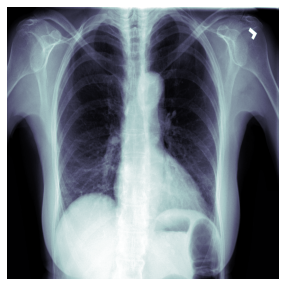

In [ ]:
#
xray_sample.show()

fastai provides the following function to create dataframe from the dicom files. Apart from reading the DICOM file, it also calculate summary statistics of the image pixels (mean/min/max/std) when px_summ is set to True

In [ ]:
#
dicom_dataframe = pd.DataFrame.from_dicoms(items, px_summ=True)
dicom_dataframe[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,PatientName,PatientID,PatientBirthDate,PatientSex,PatientAge,BodyPartExamined,ViewPosition,StudyInstanceUID,SeriesInstanceUID,StudyID,SeriesNumber,InstanceNumber,PatientOrientation,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.11405.1517875232.807474,19010101,000000.00,,CR,WSD,,view: PA,"(8, 1, 5, 5, 1, 5, 9, 8, -, a, b, 5, 1, -, 4, e, 5, 7, -, a, 4, d, e, -, 8, d, 0, b, 0, 3, 9, 9, 3, c, 5, 5)",81551598-ab51-4e57-a4de-8d0b03993c55,,F,66,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.11405.1517875232.807473,1.2.276.0.7230010.3.1.3.8323329.11405.1517875232.807472,,1,1,,1,MONOCHROME2,1024,1024,0.171000,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000018.dcm,1,0.171000,0,252,150.097208,59.213376,0.136433
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2126.1517875171.269922,19010101,000000.00,,CR,WSD,,view: AP,"(4, 4, 2, 7, 4, 9, d, 8, -, 8, 2, 7, 9, -, 4, 3, e, d, -, a, 2, a, 3, -, 8, 5, 1, 8, 3, 9, 3, e, 0, 0, e, b)",442749d8-8279-43ed-a2a3-8518393e00eb,,M,28,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.2126.1517875171.269921,1.2.276.0.7230010.3.1.3.8323329.2126.1517875171.269920,,1,1,,1,MONOCHROME2,1024,1024,0.139000,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000071.dcm,1,0.139000,0,255,144.198807,54.626554,0.071772
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.31988.1517875157.881392,19010101,000000.00,,CR,WSD,,view: PA,"(6, 3, a, 4, 0, 2, a, 4, -, 8, 2, 8, c, -, 4, c, c, 4, -, 9, 7, 6, 0, -, 4, 3, 2, 6, 0, 2, 1, 6, 2, 4, 2, 5)",63a402a4-828c-4cc4-9760-432602162425,,M,65,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.31988.1517875157.881391,1.2.276.0.7230010.3.1.3.8323329.31988.1517875157.881390,,1,1,,1,MONOCHROME2,1024,1024,0.168000,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000037.dcm,1,0.168000,0,255,176.959857,51.083963,0.036505
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.32498.1517875160.877894,19010101,000000.00,,CR,WSD,,view: AP,"(c, f, 2, a, 4, 6, 7, f, -, e, b, 2, 0, -, 4, 5, 1, 6, -, 8, f, 3, 6, -, 3, 6, d, e, 2, d, 4, 5, 4, 5, 4, e)",cf2a467f-eb20-4516-8f36-36de2d45454e,,F,48,CHEST,AP,1.2.276.0.7230010.3.1.2.8323329.32498.1517875160.877893,1.2.276.0.7230010.3.1.3.8323329.32498.1517875160.877892,,1,1,,1,MONOCHROME2,1024,1024,0.168000,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000135.dcm,1,0.168000,0,255,107.833434,65.194095,0.241501
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.2633.1517875173.805125,19010101,000000.00,,CR,WSD,,view: PA,"(9, 4, 3, a, 4, e, 9, 3, -, d, 0, 5, 8, -, 4, 8, 8, 4, -, b, c, 6, 1, -, 7, b, 6, f, b, b, 2, 8, 8, c, 8, 5)",943a4e93-d058-4884-bc61-7b6fbb288c85,,F,40,CHEST,PA,1.2.276.0.7230010.3.1.2.8323329.2633.1517875173.805124,1.2.276.0.7230010.3.1.3.8323329.2633.1517875173.805123,,1,1,,1,MONOCHROME2,1024,1024,0.194311,8,8,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/No Pneumothorax/000103.dcm,1,0.194311,0,255,96.317883,43.559422,0.267043


We have 250 samples which wouldn't be sufficient to build anything of significance. We will use it to understand the DICOM data and to learn how fastai can be used to work with medical images. 

In [ ]:
#
len(dicom_dataframe)

250

Let's take a look at the different columns. `img_min`, `img_max`, `img_mean`, `img_std`, `img_pct_window` are calculated by from_dicom fastai function.

In [ ]:
#
dicom_dataframe.columns

Index(['SpecificCharacterSet', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate',
       'StudyTime', 'AccessionNumber', 'Modality', 'ConversionType',
       'ReferringPhysicianName', 'SeriesDescription', 'PatientName',
       'PatientID', 'PatientBirthDate', 'PatientSex', 'PatientAge',
       'BodyPartExamined', 'ViewPosition', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'SeriesNumber', 'InstanceNumber',
       'PatientOrientation', 'SamplesPerPixel', 'PhotometricInterpretation',
       'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored',
       'HighBit', 'PixelRepresentation', 'LossyImageCompression',
       'LossyImageCompressionMethod', 'fname', 'MultiPixelSpacing',
       'PixelSpacing1', 'img_min', 'img_max', 'img_mean', 'img_std',
       'img_pct_window'],
      dtype='object')

We have `CR` as the Modelity which is Computed Radiograpy

In [ ]:
#
dicom_dataframe['Modality'].unique()

array(['CR'], dtype=object)

We can see the age distribution of the patient.

Text(0, 0.5, 'Frequency')

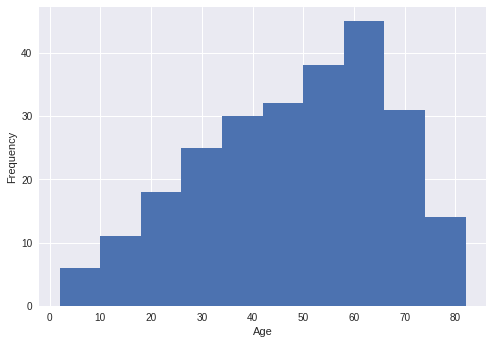

In [ ]:
#
plt.style.use('seaborn')
dicom_dataframe['PatientAge'].astype(int).hist(bins=10)
plt.xlabel('Age')
plt.ylabel('Frequency')

We have an equal number of M and F

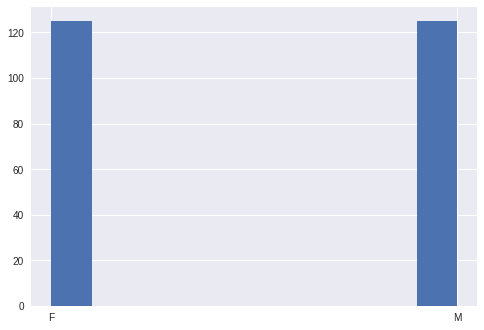

In [ ]:
#
dicom_dataframe['PatientSex'].hist()

# Building a classifier with fastai

Next, let's use `fastai.medical` to build a simple classifier. Again, we only have 250 samples which won't be enough to build anything of significance. The goal is to show how we can use `fastai.medical` to work with medical images. 

Let's get the different folders/files.

In [ ]:
#
pneumothorax_source.ls()

(#2) [Path('/root/.fastai/data/siim_small/train'),Path('/root/.fastai/data/siim_small/labels.csv')]

Let's read the `labels.csv` and see what is in it

In [ ]:
#
train = pd.read_csv(pneumothorax_source/'labels.csv')

Let's build a simple dataloader

In [ ]:
#
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                  get_x=lambda x:pneumothorax_source/f"{x[0]}",
                  get_y=lambda x:x[1],
                  splitter=RandomSplitter(),
                  batch_tfms=aug_transforms(size=400))

dls = pneumothorax.dataloaders(train.values, bs=8)

Once, we have made the dataloader, we can take a look at a batch.

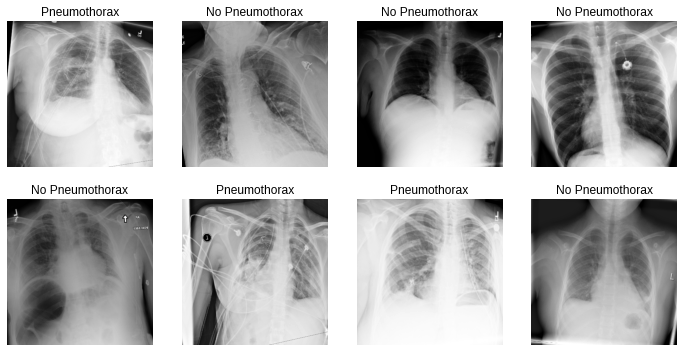

In [ ]:
#
dls.show_batch(max_n=8)

Let's use fastai's `xrestnet` model - xresnet is based on "Bag of Tricks for ResNet" paper. We also use `Mish` activation instead of the usual `ReLU` and we will use `self-attention`.

In [ ]:
#
model = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=2)

In [ ]:
# as you can see, the model expects 3 input channels (RGB) but we have single (grayscale) channel images
model[0][0]

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [ ]:
#
# Here, we will set the first layer to accept single channel image 
model[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

For the optimizer, we will use ranger which uses RAdam and Lookahead.

In [ ]:
#
learn = Learner(dls, 
                model=model, 
                loss_func=LabelSmoothingCrossEntropy(),
                metrics= accuracy,
                opt_func=ranger)

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=0.0012022644514217973)

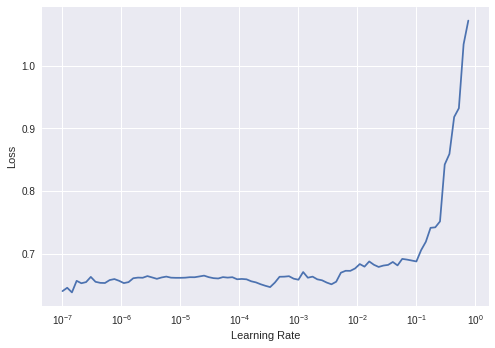

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(5, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.635151,0.681318,0.680000,00:13
1,0.629701,0.652602,0.680000,00:12
2,0.614139,0.611938,0.720000,00:13
3,0.601922,0.743685,0.640000,00:12
4,0.596375,0.660376,0.700000,00:12


# Interpreting the classifier with fastai

Among the many cool things fastai provides, interpretation is one. Let's take a look at the classifier and see how well our classifier is doing.  

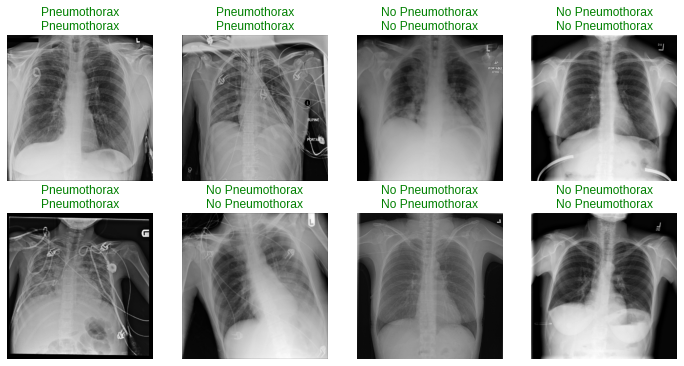

In [ ]:
learn.show_results(max_n=8)

In [ ]:
#
# Let's initiate a ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)

Let's take a look at our top_losses. Our classifier confuses No Pneumothorax for Pneumothorax. This is likely because of the lack of training data. Again, the goal here is to understand how we can use fastai and its many tools.

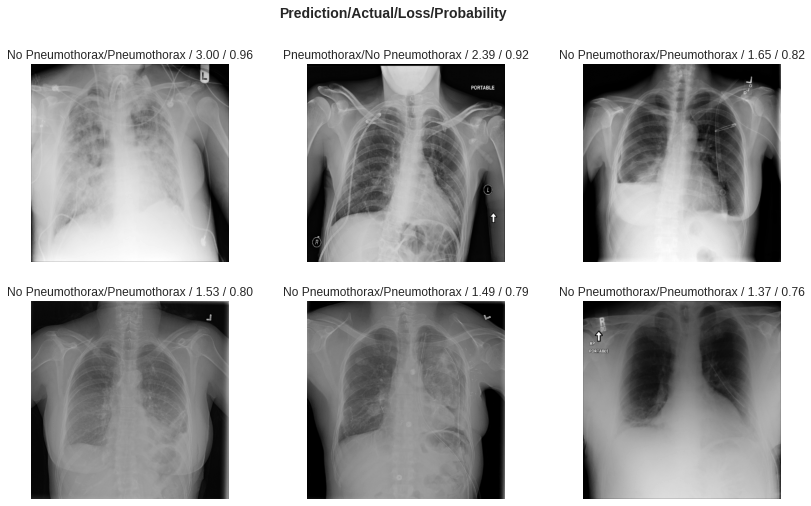

In [ ]:
#
interp.plot_top_losses(6, figsize=(14,8))


As expected, there is a lot of False Negative (predicts "No Pneumothorax" when it is "Pneumothorax")


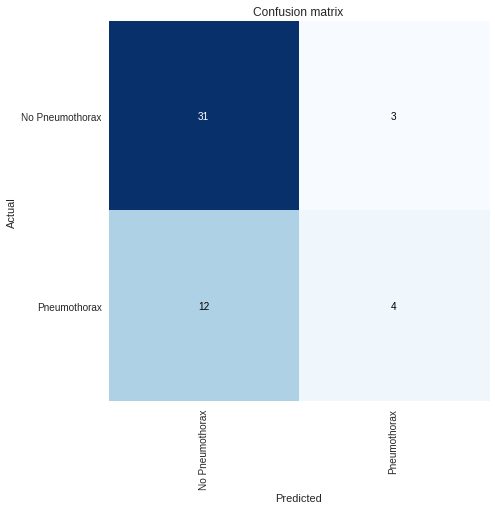

In [ ]:
#
interp.plot_confusion_matrix(figsize=(7,7))

# CAM and GradCAM

## CAM - Class Activation Map



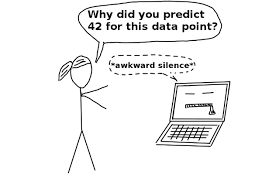

*credits: https://docs.paperspace.com/machine-learning/wiki/interpretability*

Interpretability or explainability is the degree to which a model's prediction/decision can be explained in human terms. This is a huge area of research as often ML models are said to be a black-box with no interpretability. There are certain tools being developed to address this area. Among those tools are CAM and GradCAM. 
 
Class Activation Map (CAM) uses the activation of the last convolution layer and the predictions of the last layer to plot heatmap visualization. The visualization gives an idea of why the model made its decision. In medical imaging, this sort of heatmap visualization could augment radiologists and other doctors apart from doing the classification. Fastbook has a chapter dedicated to CAM and GradCAM which can be found [here](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb).  
 
Let's see how we can make use of CAM.
 
Below, we define a hook class. Hooks are similar to callbacks and they let us inject codes into forward and backward calculation. 
 

In [ ]:
#
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

Let's define the path for no_pneumothorax and pneumothorax class

In [ ]:
#
nopneumo = (pneumothorax_source/'train').ls()[0].ls()
pneumo = (pneumothorax_source/'train').ls()[1].ls()

Then, we initiate the Hook class and use the register_forward_hook to attach the hook class to the forward function. `learn.model[-5]` would access the whole xresnet model without the head and register_forward_hook would be able to attach our hook to the last convolution layer.

In [ ]:
#
hook_output = Hook()
hook = learn.model[-5].register_forward_hook(hook_output.hook_func)

Let's define a function to grab a sampel of image either from nopneumo or pneumo folders.

In [ ]:
#
def grab_x(path, patient):
  x = first(dls.test_dl([path[patient]]))
  return x[0]

Let's define a function to get the CAM map. As you can see we make use of the einsum function. It is awesome funtion and [here](https://www.youtube.com/watch?v=pkVwUVEHmfI) is one of my fav video on this topic.

In [ ]:
#
def get_cammap(x):
    with torch.no_grad(): 
      output = learn.model.eval()(x)
    act = hook_output.stored[0]
    print(F.softmax(output, dim=-1))
    cam_map = torch.einsum('ck,kij->cij', learn.model[-1].weight, act)
    hook.remove()
    return cam_map

Then, Let's define a function to plot two images - `left_image` = input image and `right_image` = input image superimposed by the CAM activation heatmap. `idx`=0 to see nopneumo class activation and `idx`=1 to see pneumo class activation.

In [ ]:
#
def plot_cam(x, cls, cam_map, img_size=400):
    x_dec = TensorDicom(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots(1,2, figsize=(15,10))
    x_dec.show(ctx=ax[0])
    x_dec.show(ctx=ax[1])
    ax[1].imshow(cam_map[cls].detach().cpu(), alpha=0.6, extent=(0,img_size,img_size,0),
              interpolation='bilinear', cmap='magma');

Let's write a function to wrap everything. 

In [ ]:
def get_plot_cam_image(path, patient, cls):
    x = grab_x(path, patient)
    cam_map = get_cammap(x)
    plot_cam(x, cls, cam_map, img_size=400)

Below, is an example for No pneumothorax. Areas in bright yellow/orange corresponds to high activations while areas in purple corresponds to low activations. Unfortunately, our classifier hasn't learnt much to show this. Hence, lets see pic from fastbook. 

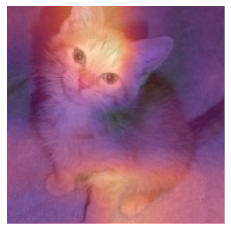

The activation map on the cat allows one to peek into model's 'reasons' for its prediction. In medical imaging, this might highlight tumors and other such abnormalities that the radiologists could further scrutanize. 

tensor([[0.8117, 0.1883]], device='cuda:0')


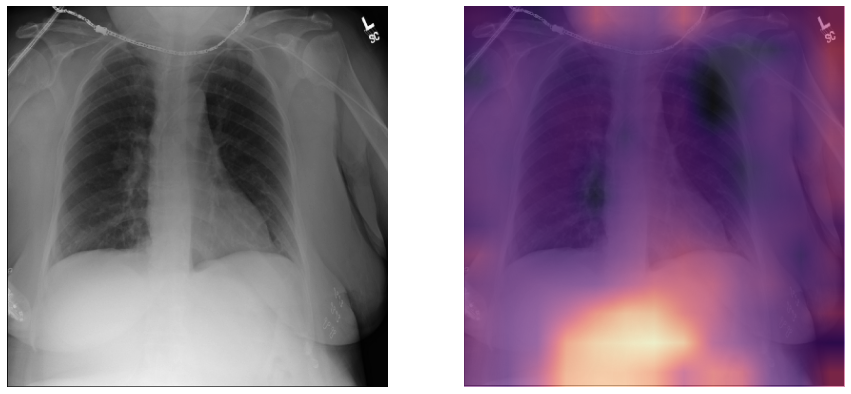

In [ ]:
# 
get_plot_image(nopneumo, 5, 0)

Below is the same image but observing for class=1 or for Pneumothorax. Some of the bright orange are around the lungs as oppose to above where for No Pneumothorax the lungs appeared purple highlighting no activation around the lungs.

tensor([[0.8117, 0.1883]], device='cuda:0')


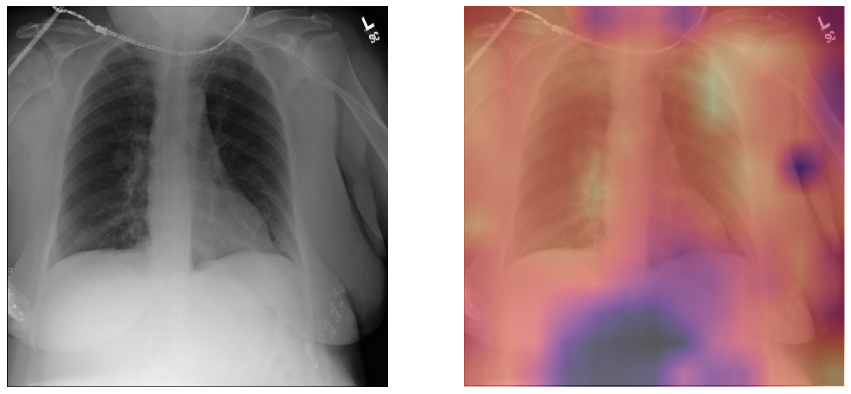

In [ ]:
# 
get_plot_image(nopneumo, 5, 1)

## GradCAM

Having seen how to use CAM in fastai. Let's take a look at GradCAM. 
 
GradCAM is similar to CAM except in GradCAM we make use of the gradient to plot the visualization. Because we use gradient, we are able to plot the visualization for the earlier `conv` layers too. With CAM, we were only able to observe the visualization for the final `conv` layer because once we obtained the activation of the conv layer, we need to multiply by the last weight matrix.This method only works for the final `conv` layer. This variant was introduced in the paper -  "[Grad-CAM: Why Did You Say That? Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1611.07450)" in 2016. 

In [ ]:
#
# A hook to store the output of a layer
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()


# A hook to store the grad of a layer
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
def get_gradcammap(x, cls, model_layer):

  with HookBwd(model_layer) as hookg:
      with Hook(model_layer) as hook:
          output = learn.model.eval()(x.cuda())
          act = hook.stored
      output[0,cls].backward()
      grad = hookg.stored
  
  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map = (w * act[0]).sum(0)

  return cam_map

In [ ]:
def plot_gcam(x, img_size=400):

    x_dec = TensorDicom(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots(1,2, figsize=(15,10))
    x_dec.show(ctx=ax[0])
    x_dec.show(ctx=ax[1])
    ax[1].imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,img_size,img_size,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
def get_plot_gcam_image(path, patient, cls, layer=-5):
    x = grab_x(path, patient)
    cam_map = get_gradcammap(x, cls, layer)
    plot_gcam(x)


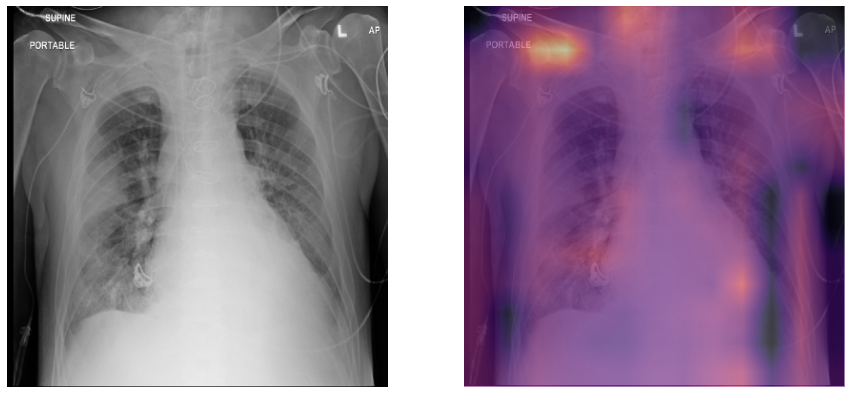

In [ ]:
get_plot_gcam_image(nopneumo, 7, cls=0, layer=learn.model[-5])

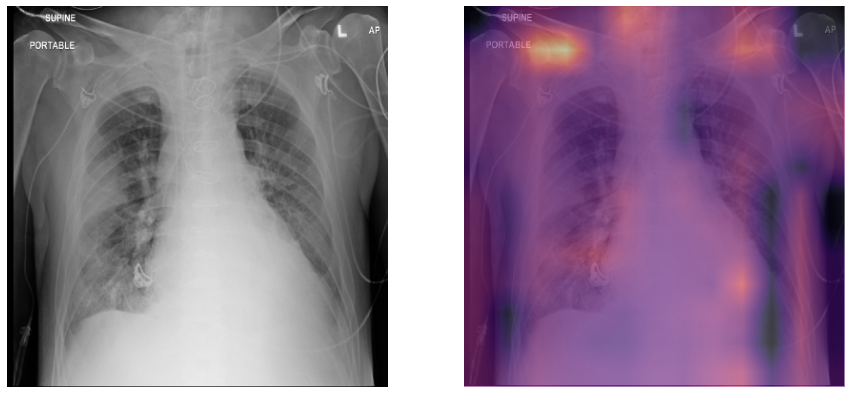

In [ ]:
get_plot_gcam_image(nopneumo, 7, cls=1, layer=learn.model[-5])

In [ ]:
get_plot_gcam_image(nopneumo, 7, cls=0, layer=learn.model[-5])

*References*

https://docs.fast.ai/tutorial.medical_imaging.html

http://dicomiseasy.blogspot.com/2011/10/introduction-to-dicom-chapter-1.html

http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1.4

https://dicom.innolitics.com/ciods/ct-image/image-plane/00280030#:~:text=All%20pixel%20spacing%20related%20Attributes,adjacent%20rows%2C%20or%20vertical%20spacing.